# 빅데이터 분석 (7주차) 10월21일
> Pytorch CNN (MNIST 3,7)

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Pytorch CNN (MNIST 3 7)]

### import 

- 5주차에 했던 MLP와 다른 모형으로 해보는 수업, 일단 5주차 내용으로 시작

In [1]:
import torch 
from fastai.vision.all import * 

In [2]:
import graphviz

In [3]:
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+ s + ';}')

### data 

`-` download data 

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
path.ls()

(#3) [Path('/home/csy/.fastai/data/mnist_sample/train'),Path('/home/csy/.fastai/data/mnist_sample/labels.csv'),Path('/home/csy/.fastai/data/mnist_sample/valid')]

`-` list 

In [6]:
threes=(path/'train'/'3').ls()
sevens=(path/'train'/'7').ls()

`-` list $\to$ image 

In [7]:
Image.open(threes[4])

`-` image $\to$ tensor 

In [8]:
tensor(Image.open(threes[4]))

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  64, 128, 128,
         191, 128,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0, 128, 255, 255, 255, 255,
         255, 255, 191,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

- 여기에서 tensor는 파이토치가 아니라 fastai에서 구현한 함수임 

`-` 여러개의 리스트를 모두 텐서로 바꿔보자. 

In [9]:
seven_tensor = torch.stack([tensor(Image.open(i)) for i in sevens]).float()/255
three_tensor = torch.stack([tensor(Image.open(i)) for i in threes]).float()/255

`-` $X$와 $y$를 만들자. 

In [10]:
seven_tensor.shape, three_tensor.shape

(torch.Size([6265, 28, 28]), torch.Size([6131, 28, 28]))

In [11]:
y=torch.tensor([0.0]*6265+ [1.0]*6131).reshape(12396,1)

In [12]:
X=torch.vstack([seven_tensor,three_tensor]).reshape(12396,-1)

In [13]:
X.shape, y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

### 기존의 MLP 모형 

${\bf X} \to {\bf WX+b} \to f({\bf WX+b}) \to \dots \to {\bf y}$
- ${\bf X}=12396 \times 784$ matrix 
- ${\bf y}=12396 \times 1$ (col) vector

`-` 교재의 모형 

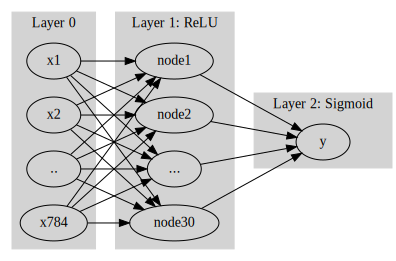

In [14]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node30" -> "y"
    label = "Layer 2: Sigmoid"
}
''')

- Layer 선형 $\to$ 2d convolution Maxpooling, ReLU 비선형 $\to$ Sigmoid 선형

`-` 왜 28$\times$28 이미지를 784개의 벡터로 만든 다음에 모형을 돌려야 하는가? 

`-` 기존에 개발된 모형이 회귀분석 기반으로 되어있어서 결국 회귀분석 틀에 짜 맞추어서 이미지자료를 분석하는 느낌 

`-` observation의 차원은 $784$가 아니라 $1\times (28\times 28)$이 되어야 맞다. 
- 이는 흑백으로 했을때, 빛의 3원색 조화 개념이 들어오면 3배로 많아질 수 있다.

In [15]:
X.shape

torch.Size([12396, 784])

In [16]:
X=X.reshape(12396,1,28,28)

In [17]:
X.shape

torch.Size([12396, 1, 28, 28])

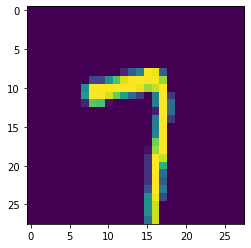

In [18]:
plt.imshow(X[776][0])

### 선형변환 대신에 2d convolution with windowsize=5

In [21]:
torch.nn.Conv2d?

Init signature:
torch.nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of chann

In [22]:
c1=torch.nn.Conv2d(1,16,5) # 입력채널=1 (흑백이므로), 출력채널=16, 윈도우크기5 

In [24]:
c1(X)

tensor([[[[-0.0881, -0.0881, -0.0881,  ..., -0.0881, -0.0881, -0.0881],
          [-0.0881, -0.0881, -0.0881,  ..., -0.0881, -0.0881, -0.0881],
          [-0.0881, -0.0881, -0.0881,  ..., -0.0881, -0.0881, -0.0881],
          ...,
          [-0.0881, -0.0881, -0.0881,  ..., -0.0881, -0.0881, -0.0881],
          [-0.0881, -0.0881, -0.0881,  ..., -0.0881, -0.0881, -0.0881],
          [-0.0881, -0.0881, -0.0881,  ..., -0.0881, -0.0881, -0.0881]],

         [[ 0.0066,  0.0066,  0.0066,  ...,  0.0066,  0.0066,  0.0066],
          [ 0.0066,  0.0066,  0.0066,  ...,  0.0066,  0.0066,  0.0066],
          [ 0.0066,  0.0066,  0.0066,  ...,  0.0066,  0.0066,  0.0066],
          ...,
          [ 0.0066,  0.0066,  0.0066,  ...,  0.0066,  0.0066,  0.0066],
          [ 0.0066,  0.0066,  0.0066,  ...,  0.0066,  0.0066,  0.0066],
          [ 0.0066,  0.0066,  0.0066,  ...,  0.0066,  0.0066,  0.0066]],

         [[-0.0872, -0.0872, -0.0872,  ..., -0.0872, -0.0872, -0.0872],
          [-0.0872, -0.0872, -

- 이동평균 개념에서의 window size랑 비슷하네
- ref: https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1
    - 선형변환한 예제 $\sum{X*w}$
    - 차원 변화(5*5 행렬인데 windowsize를 으로 주니까 3*3으로 변화)
        - 우리의 경우 28*28 $\to$ 24*24 (window size를 5로 주니까)

In [33]:
X.shape, c1(X).shape

(torch.Size([12396, 1, 28, 28]), torch.Size([12396, 16, 24, 24]))

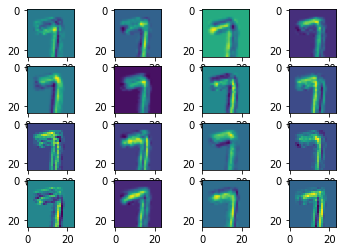

In [42]:
fig, axs = plt.subplots(4,4) 
k=0 
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(c1(X)[776][k].data) 
        k=k+1

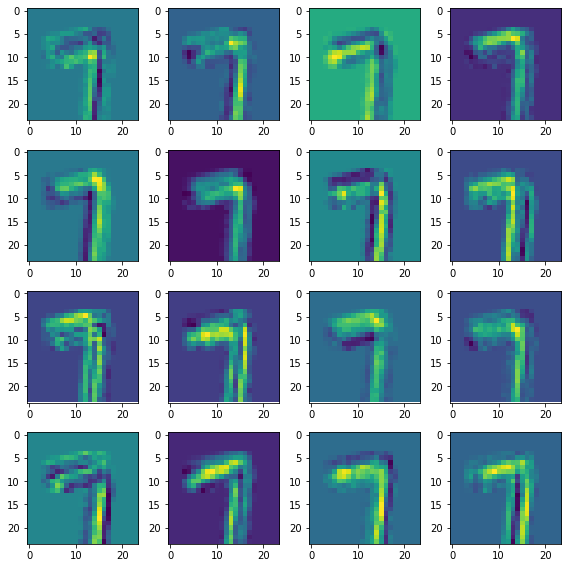

In [43]:
fig.set_figheight(8)
fig.set_figwidth(8)
fig.tight_layout()
fig

### ReLU() 대신 MaxPool2d + ReLU

#### MaxPool2d

In [44]:
m1=torch.nn.MaxPool2d(2)

In [45]:
X.shape,c1(X).shape,m1(c1(X)).shape

(torch.Size([12396, 1, 28, 28]),
 torch.Size([12396, 16, 24, 24]),
 torch.Size([12396, 16, 12, 12]))

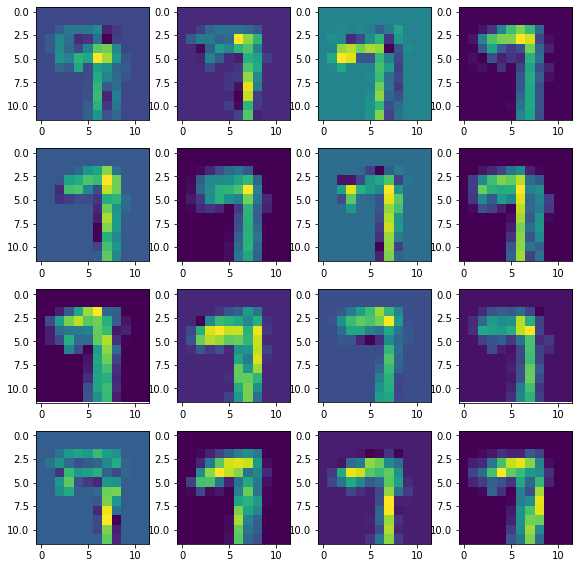

In [46]:
fig, axs = plt.subplots(4,4) 
k=0 
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(m1(c1(X))[776][k].data) 
        k=k+1
fig.set_figheight(8)
fig.set_figwidth(8)
fig.tight_layout()    

- maxpool 취하기 전의 저해상 버전,
- maxpool의 역할은 해상을 낮추는 역할

#### ReLU 

In [47]:
a1=torch.nn.ReLU()

In [48]:
X.shape,c1(X).shape, m1(c1(X)).shape, a1(m1(c1(X))).shape

(torch.Size([12396, 1, 28, 28]),
 torch.Size([12396, 16, 24, 24]),
 torch.Size([12396, 16, 12, 12]),
 torch.Size([12396, 16, 12, 12]))

In [ ]:
fig, axs = plt.subplots(4,4) 
k=0 
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(a1(m1(c1(X)))[776][k].data) 
        k=k+1
fig.set_figheight(8)
fig.set_figwidth(8)
fig.tight_layout()    

In [ ]:
torch.manual_seed(1)
_A= torch.randn((3,3))
_A

tensor([[ 0.6614,  0.2669,  0.0617],
        [ 0.6213, -0.4519, -0.1661],
        [-1.5228,  0.3817, -1.0276]])

In [ ]:
a1(_A)

tensor([[0.6614, 0.2669, 0.0617],
        [0.6213, 0.0000, 0.0000],
        [0.0000, 0.3817, 0.0000]])

### 여기에서 그냥 시그모이드에 태우자. 

`-` 현재상황 

In [ ]:
a1(m1(c1(X))).shape

torch.Size([12396, 16, 12, 12])

`-` 펼치자

In [ ]:
a1(m1(c1(X))).reshape(12396,-1).shape

torch.Size([12396, 2304])

`-` 2304의 디멘젼을 1로 만들자. 

In [ ]:
l1=torch.nn.Linear(in_features=2304,out_features=1) 

In [ ]:
l1(a1(m1(c1(X))).reshape(12396,-1))

tensor([[-0.0023],
        [-0.0947],
        [ 0.0029],
        ...,
        [-0.1033],
        [-0.1207],
        [-0.1130]], grad_fn=<AddmmBackward>)

`-` 시그모이드를 걸자. 

In [ ]:
a2=torch.nn.Sigmoid() 
a2(l1(a1(m1(c1(X))).reshape(12396,-1)))

tensor([[0.4994],
        [0.4764],
        [0.5007],
        ...,
        [0.4742],
        [0.4699],
        [0.4718]], grad_fn=<SigmoidBackward>)

### networks 설계 

In [ ]:
net = nn.Sequential(
    c1, # 컨볼루션(선형)
    m1, # 맥스풀링(비선형) -- 효과? 이미지를 계층적으로 파악할 수 있게함 
    a1, # 렐루(비선형) 
    
    a1(m1(c1(X))).reshape(12396,-1), ## 이걸 구현해야하는데?? 
    
    l1) 
## 마지막의 a2는 생략한다. torch.nn..BCEWithLogitsLoss()에 내장되어 있을것이므로 

TypeError: torch.FloatTensor is not a Module subclass

In [ ]:
net = nn.Sequential(
    c1, # 컨볼루션(선형)
    m1, # 맥스풀링(비선형) -- 효과? 이미지를 계층적으로 파악할 수 있게함 
    a1, # 렐루(비선형) 
    
#    a1(m1(c1(X))).reshape(12396,-1), ## 이걸 구현해야하는데?? 
    
    l1) 
## 마지막의 a2는 생략한다. torch.nn..BCEWithLogitsLoss()에 내장되어 있을것이므로 


`-` 결국 주석처리한 부분을 구현해야함. 

`-` `c1`,`m1`,`a1`,`l1`의 공통점 

- 무언가를 상속받는 클래스에서 생성된 인스턴스이다. 
- forward메소드가 있다. 

`-` custom layer를 만드는 방법 
- torch.nn.Module을 상속받아서 클래스를 하나 만든다. 
- forward 메소드를 정의한다. (다음레이어로 리턴할 값)

In [ ]:
class Flatten(torch.nn.Module):
    def forward(self,x): 
        return x.reshape(12396,-1)

In [ ]:
flatten=Flatten()

In [ ]:
flatten(a1(m1(c1(X)))).shape

torch.Size([12396, 2304])

`-` 잘 구현이 된것 같다. 

In [ ]:
net = nn.Sequential(
    c1, # 컨볼루션(선형)
    m1, # 맥스풀링(비선형) -- 효과? 이미지를 계층적으로 파악할 수 있게함 
    a1, # 렐루(비선형) 
    flatten,#    a1(m1(c1(X))).reshape(12396,-1), ## 이걸 구현해야하는데?? 
    l1) 
## 마지막의 a2는 생략한다. torch.nn..BCEWithLogitsLoss()에 내장되어 있을것이므로 

`-` 손실함수와 옵티마이저 정의 

In [ ]:
loss_fn=torch.nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(net.parameters())

`-` step1~4

In [ ]:
for epoc in range(200): 
    ## 1 
    yhat=net(X)
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad()

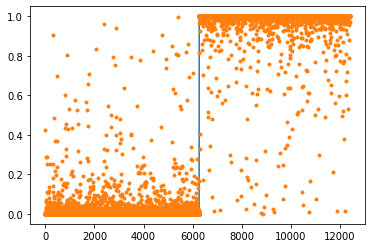

In [ ]:
plt.plot(y)
plt.plot(a2(yhat.data),'.')

In [ ]:
ypred=a2(yhat.data)>0.5 

In [ ]:
sum(ypred==y)/12396

tensor([0.9927])

`-` 좀 더 성능이 좋아졌다. (이미 좋았는데 약간 더 좋아짐) 

### 숙제 

`-` torch.nn.MaxPool2d(2) 대신 torch.nn.MaxPool2d(3) 을 사용하여 모형을 학습해보고 결과비교